# Importação das bibliotecas

In [1000]:
import numpy as np # criação e manipulação de vetores
import matplotlib.pyplot as plt # graficos
from scipy.integrate import ode # integracao
from scipy.integrate import odeint 
import pandas as pd 

- [scipy.integrate.ode manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html)

- [scipy.integrate.odeint manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

In [1001]:
ft = 14
plt.rcParams.update({'font.size':ft})

# Definição das condições iniciais

In [1002]:
NVEnt = 7   # numero de variaveis de estado ou quantas ODEs temos

VarEnt = np.zeros(NVEnt) # I,M,λ0,λ1,λ2,T,Tc

VarEnt[0] = 0.5888 # mol/L  # I
VarEnt[1] = 8.6981 # mol/L  # M
VarEnt[2] = 2.7547e-4 # mol/L  # I
VarEnt[3] = 16.110 # g/L  # M

MW_M = 104.150 # g/mol
MW_S = 106.167 # g/mol
PD0=1.5; # Polidispersao padrao +/-0.01
VarEnt[4] = PD0*VarEnt[3]**(2/(MW_M*2.7547e-4)) # g/L

VarEnt[5] = 323.56 # K temperatura reator

VarEnt[6] = 295 # K - Inlet temperature of cooling jacket fluid

I0 = VarEnt[0]
M0 = VarEnt[1]
λ0 = VarEnt[2]
T0 = VarEnt[5]
Tcf = VarEnt[6] # K - Temperature of cooling jacket fluid

In [1003]:
VarEnt

array([5.88800000e-01, 8.69810000e+00, 2.75470000e-04, 1.61100000e+01,
       2.10367673e+84, 3.23560000e+02, 2.95000000e+02])

In [1004]:
t0 = 0 # min - tempo inicial da reacao
tf = 100 # min - tempo final da reacao
tempo = np.linspace(t0,tf,100)

# Parâmetros do problema

In [1005]:
Qi=108 # L/h fluxo iniciador
Qs=459 # L/h fluxo solvente
Qm=378 # L/h fluxo do monomero

Qt=Qi+Qm+Qs #L/h fluxo total
Qc = 471.6 #L/h fluxo  corrente fria

global V 
V = 3000 # L volume do reator
Vc = 3312.4  # L Volume of cooling jacket fluid

Ad=2.142*10**17 # 1/h
Ap=3.816*10**10 # L.gmol/h
At=4.50*10**12 # L.gmol/h

Ed=14897 # K
Ep=3557 # K
Et=843 # K

fi=0.6 # eficiencia do iniciador

A1 = 2.57 - 5.05e-3*T0
A2 = 9.56 - 1.76e-2*T0
A3 = -3.03 + 7.85e-3*T0

global kd, kp, kt

kd=Ad*np.exp(-Ed/T0); # L/mol.h

kp=Ap*np.exp(-Ep/T0); # L/mol.h

x = 0 # conversao inicial
kt0=At*np.exp(-Et/T0); # L/mol.h
kt = kt0*np.exp(-2*(A1*x + A2*x**2 + A3*x**3))

hArea = 1.05*10**6 # J/Kh 

deltaH = 6.99*10**4 # J/mol - Heat of polymerization

densidadeCp = 1506 # J/KL - Mean heat capacity of reactor fluid 
densidadeCpCool= 4043 # J/KL - Heat capacity of cooling jacket fluid

# Função com o sistema de EDOs

In [1006]:
def reac(t,Y):
    global V,μ0,μ1,μ2
    
    NEq = len(Y)
    
    I  = Y[0]
    M  = Y[1]
    λ0 = Y[2]
    λ1 = Y[3]
    λ2 = Y[4]
    T  = Y[5]
    Tc = Y[6]    
        
   
    A1 = 2.57 - 5.05e-3*T
    A2 = 9.56 - 1.76e-2*T
    A3 = -3.03 + 7.85e-3*T
           
    x = (M0 - M)/M0 # conversao
    kt0=At*np.exp(-Et/T); # L/mol.h
    kt = kt0*np.exp(-2*(A1*x + A2*x**2 + A3*x**3))      
    
    
    P=((2*fi*kd*I)/kt)**0.5
    
    dYdt = np.zeros(NEq)
    dYdt[0] = (1/V)*(Qi*I0-Qt*I)-(kd*I); # dI/dt
    dYdt[1] = (1/V)*(Qm*M0-Qt*M)-(kp*M*P); # dM/dt ou dy/dt
    dYdt[2] = (0.5*kt*(P**2))-(Qt*λ0/V); # dλ0/dt
    dYdt[3] = (MW_M*kp*M*P)-(Qt*λ1/V); # dλ1/dt
    dYdt[4] = (5*MW_M*kp*M*P)+3*MW_M*(M**2)*((kp**2)/kt)-(Qt*λ2/V); # dλ2/dt
    dYdt[5] = (Qt*(T0-T)/V) + (((deltaH)/(densidadeCp))*(kp*M*P)) - ((hArea)/(densidadeCp*V))*(T-Tc) #dT/dt
    dYdt[6] = (Qc*(Tcf-Tc)/Vc) + ((hArea)/(densidadeCpCool*Vc))*(T-Tc) #dTc/dt   
 
    return dYdt 

# Chamada do integrador

In [1007]:
global μ0,μ1,μ2

In [1008]:
μ0,μ1,μ2 = 0,0,0

In [1009]:
Y = np.zeros((len(tempo),NVEnt))
μ = np.zeros((len(tempo),3))
YY = ode(reac).set_integrator('lsoda',method = 'bdf')
YY.set_initial_value(VarEnt,t0)

j = 0 # tempo
while YY.successful():
    Y[j,:] = YY.y
    μ[j,0] = μ0
    μ[j,1] = μ1
    μ[j,2] = μ2
    
    #print('iteracao:',j,'tempo atual:',YY.t)
    j += 1
    if YY.t >= tf:
        break
    YY.integrate(tempo[j])

# Análise dos resultados

In [1010]:
I  = Y[:,0]
M  = Y[:,1]
λ0 = Y[:,2]
λ1 = Y[:,3]
λ2 = Y[:,4]
T  = Y[:,5]
Tc = Y[:,6]

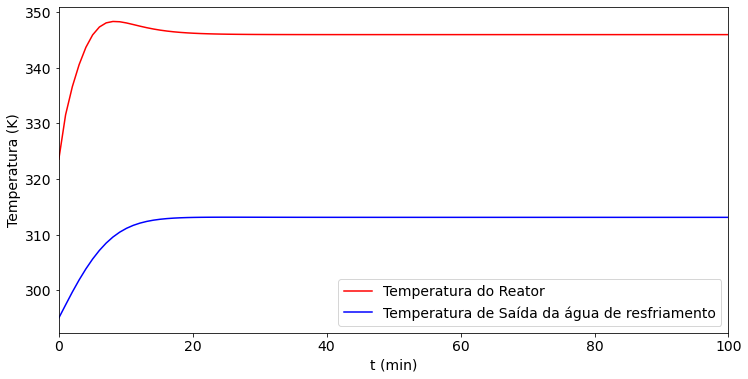

In [1011]:
fig,ax = plt.subplots(figsize=[12,6])
plt.plot(tempo,T,color = 'red', label = 'Temperatura do Reator')
plt.plot(tempo,Tc,color = 'blue',  label = 'Temperatura de Saída da água de resfriamento')
plt.xlabel('t (min)')
plt.ylabel('Temperatura (K)')
plt.xlim([0,tf])
plt.legend()
plt.show()

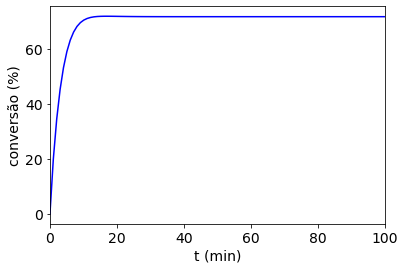

In [1012]:
x = (M0 - M)/M0

#fig,ax = plt.subplots(figsize=[12,6])
plt.plot(tempo,x*100,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('conversão (%)')
plt.xlim([0,tf])
plt.show() 

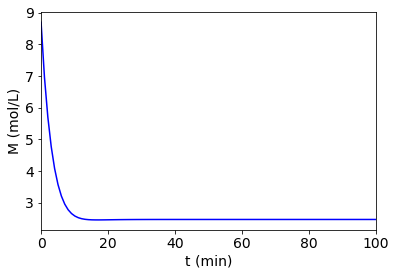

In [1013]:
plt.plot(tempo,M,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('M (mol/L)')
plt.xlim([0,tf])
#plt.ylim([0,0.05])
plt.savefig('M2.png',bbox_inches = 'tight')
plt.show()

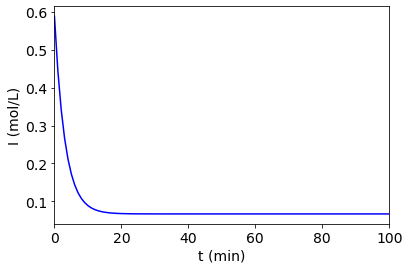

In [1014]:
plt.plot(tempo,I,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('I (mol/L)')
plt.xlim([0,tf])
#plt.ylim([0,0.05])
plt.savefig('M2.png',bbox_inches = 'tight')
plt.show()

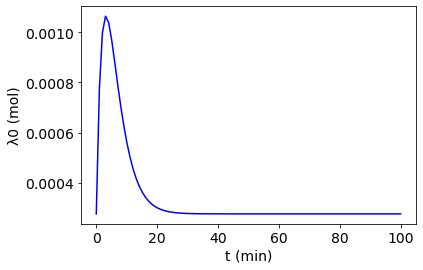

In [1015]:
plt.plot(tempo,λ0,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('λ0 (mol)')
plt.show()

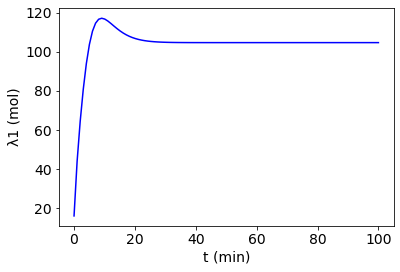

In [1016]:
plt.plot(tempo,λ1,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('λ1 (mol)')
plt.show()

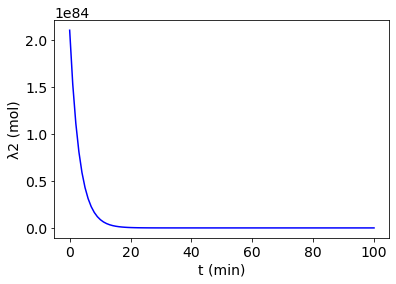

In [1017]:
plt.plot(tempo,λ2,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('λ2 (mol)')
plt.show()

- massas molares médias:

In [1018]:
Mn = λ1/λ0*MW_M
Mw = λ2/λ1*MW_M
D = Mw/Mn 

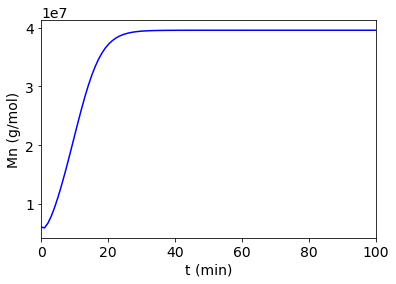

In [1019]:
plt.plot(tempo,Mn,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('Mn (g/mol)')
plt.xlim([0,tf])
#plt.ylim([0,60000])
plt.show() 

In [1020]:
Mn = (λ1+μ1)/(λ0+μ0)*MW_M
Mw = (λ2+μ2)/(λ1+μ1)*MW_M
D = Mw/Mn 

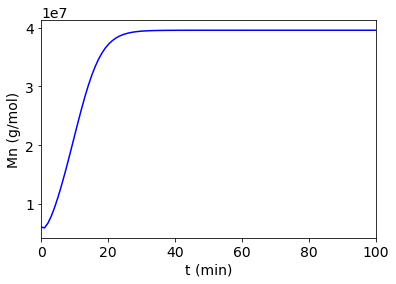

In [1021]:
plt.plot(tempo,Mn,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('Mn (g/mol)')
plt.xlim([0,tf])
#plt.ylim([0,60000])
plt.show() 

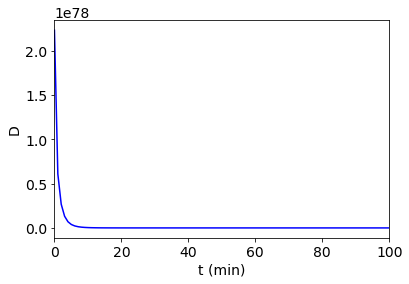

In [1022]:
plt.plot(tempo,D ,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('D')
plt.xlim([0,tf])
plt.show() 

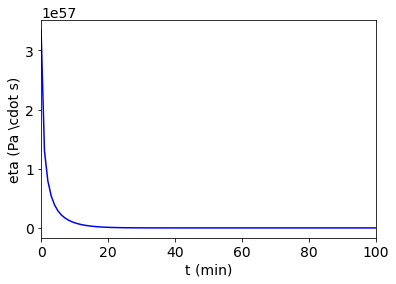

In [1023]:
eta = 0.0012*((MW_M*λ2)/λ1)**(0.71)

plt.plot(tempo,eta,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('eta (Pa \cdot s)')
plt.xlim([0,tf])
plt.show() 

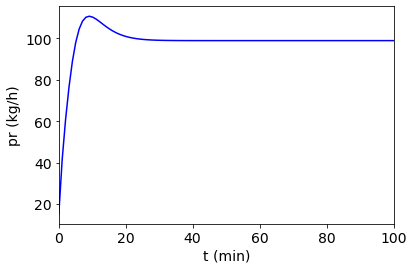

In [1024]:
pr = (Qt*λ1)/1000

plt.plot(tempo,pr,color = 'blue')
plt.xlabel('t (min)')
plt.ylabel('pr (kg/h)')
plt.xlim([0,tf])
plt.show() 